In [1]:
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
from src import geoname_taxonomy_recursive
import os
import matplotlib.pyplot as plt

config = BaseConfig(version=2).get_args(db_name="geonames")

# 1. Initial data

In [2]:
feature_codes_df = DataReader.load_csv(config.feature_codes, sep='\t', 
                                       names=["feature-code", "name", "description"])
feature_codes_df = feature_codes_df.drop(feature_codes_df[feature_codes_df['feature-code'].isnull()].index)
feature_codes_df['level-1'] = feature_codes_df['feature-code'].apply(lambda X: str(X)[0])
feature_codes_df['level-3'] = feature_codes_df['feature-code'].apply(lambda X: str(X)[2:])

level2_mapper = {}
for group, group_df in feature_codes_df.groupby("level-1"):
    group_df_level2_taxonomy = geoname_taxonomy_recursive(group_df['level-3'].tolist(), depth=config.depth)
    print(f"group {group}: number of depth-2 items:‌ {len(group_df_level2_taxonomy)}")
    for depth2_name, depth2_items in group_df_level2_taxonomy.items():
        for depth3_name, depth3_items in depth2_items.items():
                for depth3_item in depth3_items:
                    level2_mapper[depth3_item] = depth3_name

feature_codes_df['level-2'] = feature_codes_df['level-3'].map(level2_mapper)
level3_columns = feature_codes_df.pop("level-3")
feature_codes_df.insert(5, "level-3", level3_columns)
# DataWriter.write_df(feature_codes_df, path=config.processed_feature_codes)

all_countries_df = DataReader.load_csv(config.all_countries, sep='\t', low_memory=False, 
                                       names=["geonameid", "name", "asciiname", "alternatenames","latitude",
                                             "longitude", "feature-class", "feature-code", "country-code", "cc2",
                                             "admin1-code", "admin2-code", "admin3-code", "admin4-code", "population",
                                             "elevation", "dem", "timezone", "modification-date"])[["name", "asciiname", "country-code",
                                                                                                    "feature-class", "feature-code"]]
all_countries_df = all_countries_df.drop(all_countries_df[all_countries_df['feature-class'].isnull()].index)
all_countries_df.rename(columns={"feature-class":"level-1", "feature-code":"level-3"}, inplace=True)
all_countries_df['level-2'] = all_countries_df['level-3'].map(level2_mapper)
level3_columns = all_countries_df.pop("level-3")
all_countries_df.insert(5, "level-3", level3_columns)
# DataWriter.write_df(all_countries_df, path=config.processed_all_countries)

group A: number of depth-2 items:‌ 6
group H: number of depth-2 items:‌ 57
group L: number of depth-2 items:‌ 34
group P: number of depth-2 items:‌ 2
group R: number of depth-2 items:‌ 12
group S: number of depth-2 items:‌ 115
group T: number of depth-2 items:‌ 62
group U: number of depth-2 items:‌ 47
group V: number of depth-2 items:‌ 11


In [3]:
display(all_countries_df.head(5))

display(feature_codes_df.head(5))

print(f"The size of dataset set is:{all_countries_df.shape[0]}")
print(f"The size of feature codes set is:{feature_codes_df.shape[0]}")
print(f"Number of countries are: {len(all_countries_df['country-code'].value_counts())}")
print("-"*50)
print(f"Number of feature codes in Level 1: {len(all_countries_df['level-1'].value_counts())}")
print(f"Number of feature codes in Level 2: {len(all_countries_df['level-2'].value_counts())}")
print(f"Number of feature codes in Level 3: {len(all_countries_df['level-3'].value_counts())}")
print("-"*50)

,name,asciiname,country-code,level-1,level-2,level-3
0,Pic de Font Blanca,Pic de Font Blanca,AD,T,PK,PK
1,Roc Mélé,Roc Mele,AD,T,MT,MT
2,Pic des Langounelles,Pic des Langounelles,AD,T,PK,PK
3,Pic de les Abelletes,Pic de les Abelletes,AD,T,PK,PK
4,Estany de les Abelletes,Estany de les Abelletes,AD,H,LK,LK


,feature-code,name,description,level-1,level-2,level-3
0,A.ADM1,first-order administrative division,a primary administrative division of a country...,A,ADM,ADM1
1,A.ADM1H,historical first-order administrative division,a former first-order administrative division,A,ADM,ADM1H
2,A.ADM2,second-order administrative division,a subdivision of a first-order administrative ...,A,ADM,ADM2
3,A.ADM2H,historical second-order administrative division,a former second-order administrative division,A,ADM,ADM2H
4,A.ADM3,third-order administrative division,a subdivision of a second-order administrative...,A,ADM,ADM3


The size of dataset set is:12350450
The size of feature codes set is:680
Number of countries are: 252
--------------------------------------------------
Number of feature codes in Level 1: 9
Number of feature codes in Level 2: 404
Number of feature codes in Level 3: 675
--------------------------------------------------


Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

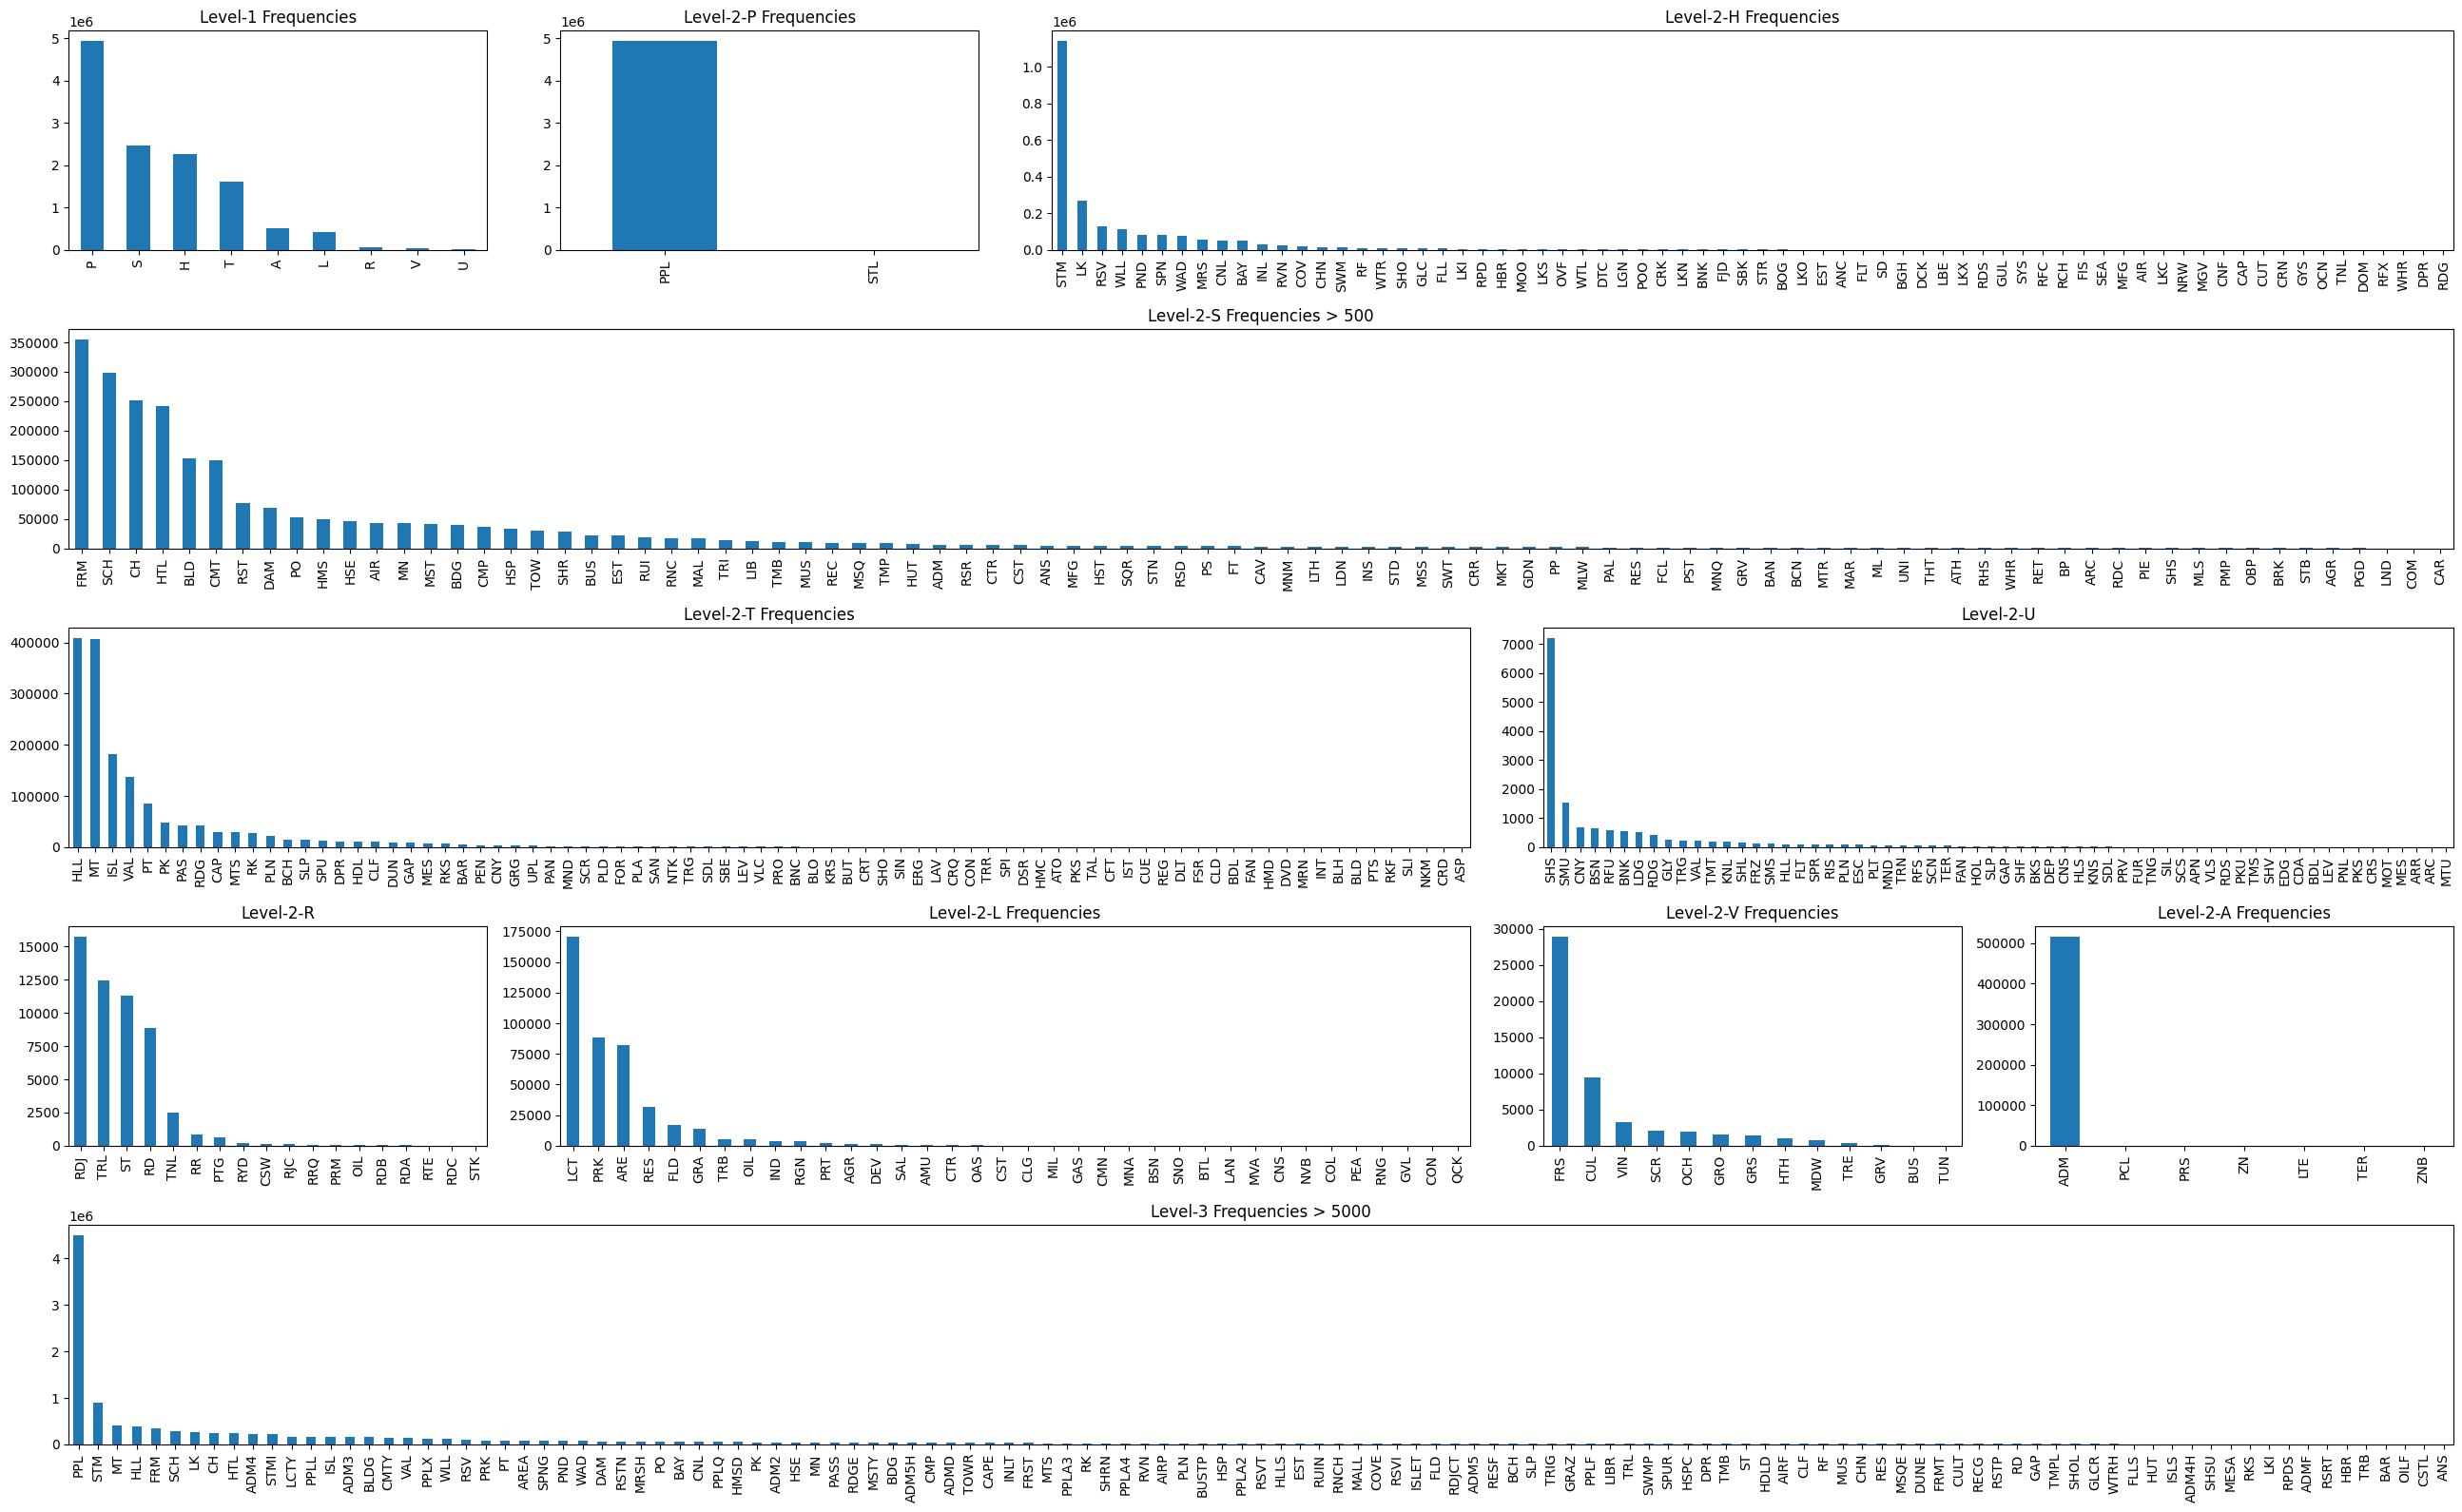

In [5]:
fig = plt.figure(figsize=(26,16))
plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().loc[lambda X: X>500].plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

# 2. Make Level 2 reductions

**consider level 2 and set the upper bound for the number of classes, a maximum of 10 top frequent classes were considered in each level.**


In [6]:
def make_level2_reduction(df, max_class_no):
    dfs = []
    for group_name, df in df.groupby("level-1"):
        if len(df['level-2'].unique()) > max_class_no:
            df = df[df['level-2'].isin(list(df['level-2'].value_counts()[:max_class_no].index))]
        dfs.append(df)            
    df = pd.concat(dfs)
    return df

In [7]:
all_countries_df = make_level2_reduction(all_countries_df, max_class_no=10)

Text(0.5, 1.0, 'Level-2-A Frequencies')

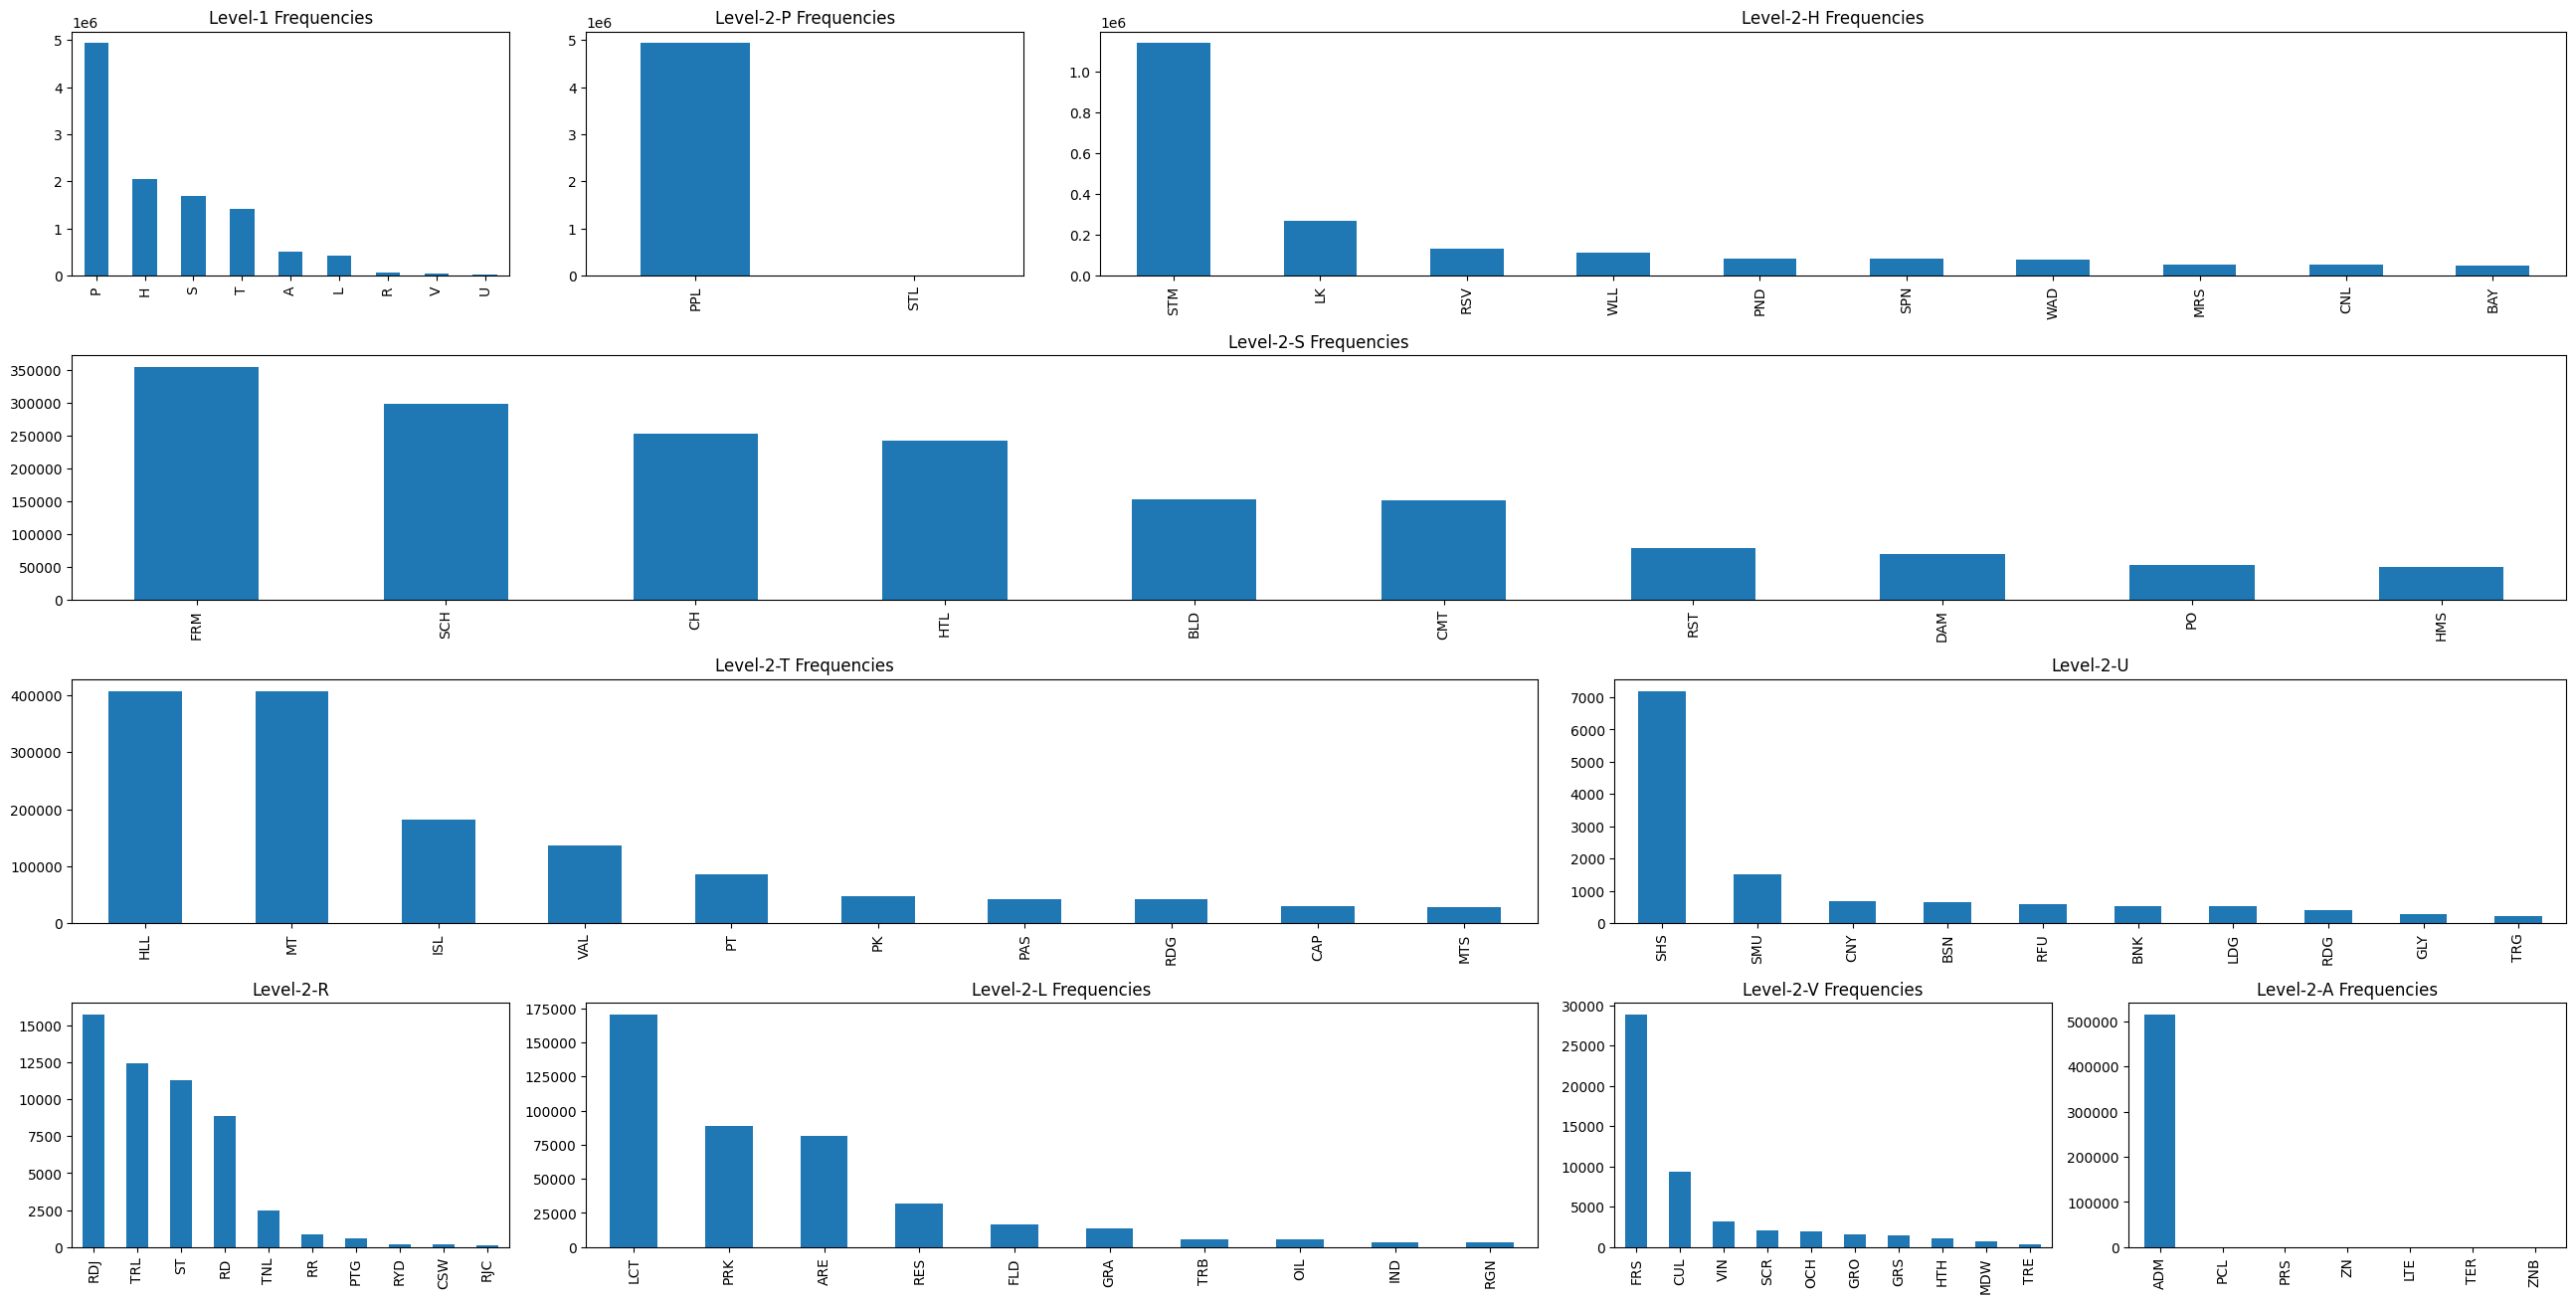

In [8]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

# ax10 = fig.add_subplot(5, 5, (21, 25))
# all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
# ax10.set_title('Level-3 Frequencies > 5000')

# 3. Make Level 1 based reductions

**Consider level 1 and set the upper bound for the number of samples in each level-1 class based on the frequency of samples in each class frequency less than 1M**


In [9]:
def make_level3_reduction(df, count_no):
    dfs = []
    for group_name, df in df.groupby("level-1"):
        if df.shape[0] > count_no:
            df = df.sample(count_no, random_state=222, replace=False)
        dfs.append(df)            
    df = pd.concat(dfs)
    return df

In [10]:
all_countries_df = make_level3_reduction(all_countries_df, count_no=1_000_000)

Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

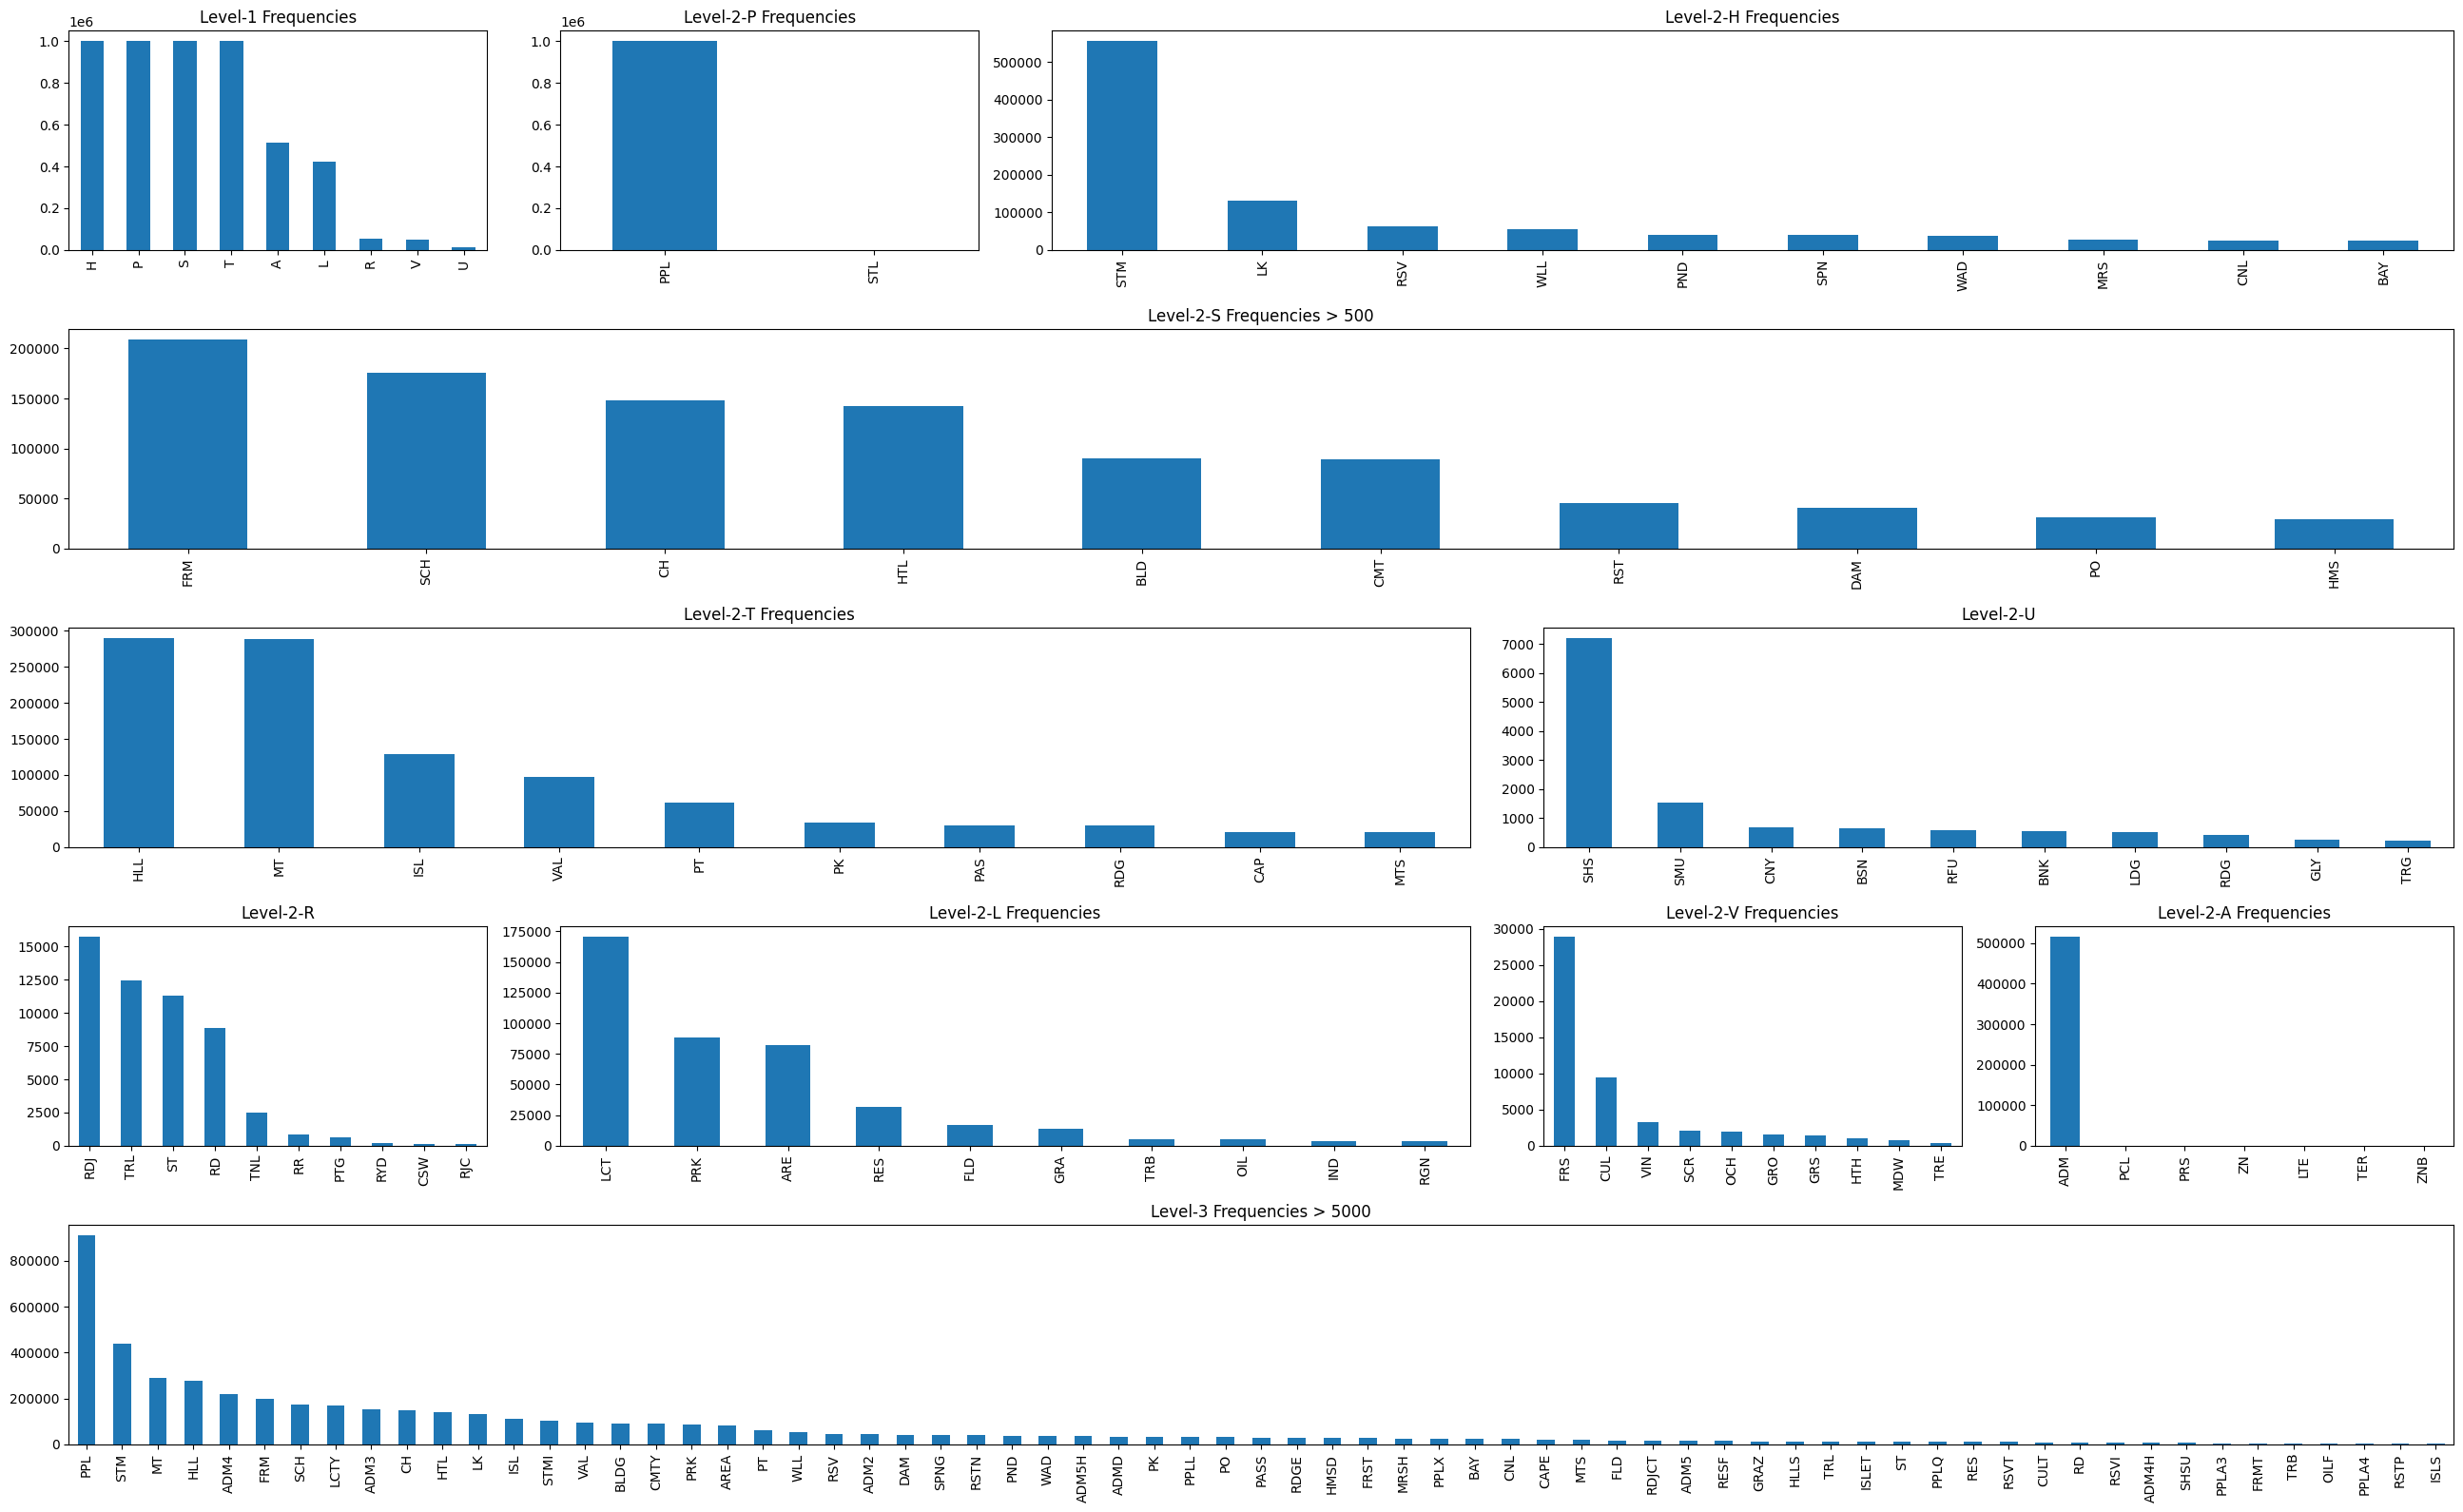

In [11]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

# 4. More Analysis and  conclusions

According to the plot and statistics dataframe (in this table colored classes are going to be considered, we also made some combinations for classes, particularly for Level-3) we can move forward with this dataset in the following manner:

- [ ] According to Level-2-P table (the second table). It is better to remove this from Level-2 and only consider PPL in Level 3 and keep P in level 1. Because the Level-2-P class frequencies are:
```
PPL    999952
STL        44
```
Due to this highly imbalanced nature of Level-2-P we may not be able to consider this level.

- [ ] The same scenario happens to Level 1 class A. Its frequencies in Level-2-A for level-2 classes are as follows:
```
ADM    515004
PCL       264
PRS       197
ZN         33
LTE        18
TER         7
ZNB         4
```
I recommend removing Level-2-A and considering only Level-3-ADM for Level-3 samples and keeping all samples for Level-1.

- [ ] Most of the classes in Level-2 has only a single class in Level-3. This has no use for analysis from our perspective. For example, Level-3-L-LCT has only 1 class in level 3. So we might ignore all of the classes in Level-3 that have this condition.

- [ ] Classes in Level-2 might have less than 1000 samples so we are interested in ignoring them in both Level-2 and Level-3s. for example Level-2-U and Level-3-U classes are ignored.



In [12]:
all_countries_df.head(2)

,name,asciiname,country-code,level-1,level-2,level-3
232,Solà d’Encamp,Sola d'Encamp,AD,A,ADM,ADMD
355,Sant Julià de Lòria,Sant Julia de Loria,AD,A,ADM,ADM1


In [24]:
stat_df = pd.DataFrame(all_countries_df[['level-1', 'level-2', 'level-3']].groupby("level-1").value_counts())

stat_df.to_csv("geoname.stats.csv")

display(stat_df.head(3))

0
level-1 level-2 level-3        
A       ADM     ADM4     218216
                ADM3     152061
                ADM2      44893

In [42]:
print("Current size of dataset is:", all_countries_df.shape[0])

print("-"*60)

print("Level 1 class FQs:\n", all_countries_df['level-1'].value_counts())

Current size of dataset is: 5053328
------------------------------------------------------------
Level 1 class FQs:
 H    1000000
P    1000000
S    1000000
T    1000000
A     515531
L     421912
R      52837
V      50453
U      12595
Name: level-1, dtype: int64


In [40]:
print("Level 2 class FQs for P:\n", all_countries_df.groupby("level-1").get_group("P")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for P-PPL:\n", all_countries_df.groupby("level-2").get_group("PPL")['level-3'].value_counts())

Level 2 class FQs for P:
 PPL    999952
STL        44
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for P-PPL:
 PPL      910218
PPLL      33454
PPLX      26208
PPLQ      10215
PPLA3      5779
PPLA4      5490
PPLA2      4158
PPLF       2746
PPLA        697
PPLW        570
PPLH        255
PPLCH        56
PPLC         44
PPLS         28
PPLR         25
PPLA5         6
PPLG          3
Name: level-3, dtype: int64


In [45]:
print("Level 2 class FQs for H:\n", all_countries_df.groupby("level-1").get_group("H")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for H-STM:\n", all_countries_df.groupby("level-2").get_group("STM")['level-3'].value_counts())

Level 2 class FQs for H:
 STM    555255
LK     131282
RSV     63626
WLL     54711
PND     40866
SPN     39815
WAD     37467
MRS     26776
CNL     25355
BAY     24847
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for H-STM:
 STM      441206
STMI     105040
STMC       2342
STMD       1971
STMB       1839
STMM       1007
STMX        857
STMA        546
STMH        159
STMIX       104
STMSB        86
STMQ         83
STMS         15
Name: level-3, dtype: int64


In [47]:
print("Level 2 class FQs for S:\n", all_countries_df.groupby("level-1").get_group("S")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for S-FRM:\n", all_countries_df.groupby("level-2").get_group("FRM")['level-3'].value_counts())

Level 2 class FQs for S:
 FRM    208700
SCH    175760
CH     148520
HTL    142210
BLD     89689
CMT     88825
RST     45680
DAM     40406
PO      31130
HMS     29080
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for S-FRM:
 FRM     200316
FRMT      5750
FRMQ      2495
FRMS       139
Name: level-3, dtype: int64


In [49]:
print("Level 2 class FQs for T:\n", all_countries_df.groupby("level-1").get_group("T")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for T-HLL:\n", all_countries_df.groupby("level-2").get_group("HLL")['level-3'].value_counts())

Level 2 class FQs for T:
 HLL    289306
MT     288370
ISL    128921
VAL     97026
PT      61135
PK      33657
PAS     30388
RDG     30022
CAP     20769
MTS     20406
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for T-HLL:
 HLL     275738
HLLS     13568
Name: level-3, dtype: int64


In [50]:
print("Level 2 class FQs for A:\n", all_countries_df.groupby("level-1").get_group("A")['level-2'].value_counts())

Level 2 class FQs for A:
 ADM    515004
PCL       264
PRS       197
ZN         33
LTE        18
TER         7
ZNB         4
Name: level-2, dtype: int64


In [53]:
print("Level 2 class FQs for L:\n", all_countries_df.groupby("level-1").get_group("L")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for L-LCT:\n", all_countries_df.groupby("level-2").get_group("LCT")['level-3'].value_counts())

Level 2 class FQs for L:
 LCT    170315
PRK     88566
ARE     81810
RES     31840
FLD     16785
GRA     13963
TRB      5653
OIL      5550
IND      3834
RGN      3596
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for L-LCT:
 LCTY    170315
Name: level-3, dtype: int64


In [57]:
print("Level 2 class FQs for R:\n", all_countries_df.groupby("level-1").get_group("R")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for R-RDJ:\n", all_countries_df.groupby("level-2").get_group("RDJ")['level-3'].value_counts())


print("-"*60)

print("Level 3 class FQs for R-TRL:\n", all_countries_df.groupby("level-2").get_group("TRL")['level-3'].value_counts())

Level 2 class FQs for R:
 RDJ    15717
TRL    12444
ST     11321
RD      8839
TNL     2479
RR       886
PTG      622
RYD      213
CSW      168
RJC      148
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for R-RDJ:
 RDJCT    15717
Name: level-3, dtype: int64
------------------------------------------------------------
Level 3 class FQs for R-TRL:
 TRL    12444
Name: level-3, dtype: int64


In [63]:
print("Level 2 class FQs for V:\n", all_countries_df.groupby("level-1").get_group("V")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for V-CUL:\n", all_countries_df.groupby("level-2").get_group("CUL")['level-3'].value_counts())
print("-"*60)

print("Level 3 class FQs for V-FRS:\n", all_countries_df.groupby("level-2").get_group("FRS")['level-3'].value_counts())


Level 2 class FQs for V:
 FRS    28842
CUL     9385
VIN     3214
SCR     2037
OCH     1929
GRO     1532
GRS     1417
HTH     1027
MDW      729
TRE      341
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for V-CUL:
 CULT    9385
Name: level-3, dtype: int64
------------------------------------------------------------
Level 3 class FQs for V-FRS:
 FRST     28837
FRSTF        5
Name: level-3, dtype: int64


In [67]:
print("Level 2 class FQs for U:\n", all_countries_df.groupby("level-1").get_group("U")['level-2'].value_counts())

print("-"*60)

print("Level 3 class FQs for U-SMU:\n", all_countries_df.groupby("level-2").get_group("SMU")['level-3'].value_counts())

Level 2 class FQs for U:
 SHS    7197
SMU    1522
CNY     695
BSN     639
RFU     582
BNK     539
LDG     518
RDG     417
GLY     271
TRG     215
Name: level-2, dtype: int64
------------------------------------------------------------
Level 3 class FQs for U-SMU:
 SMU    1522
Name: level-3, dtype: int64
